# Pass heat maps

Per creare le heat maps dei passaggi useremo un contesto specifico. Il contesto consiste nel prendere in considerazione soltanto i passaggi effettuati 15 secondi prima di un tiro.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch, Sbopen, VerticalPitch

Calcoliamo il numero di partire del **AC Milan** per effettuare la Normalizzazione in seguito.

In [21]:
parser = Sbopen()
df_m = parser.match(competition_id=55, season_id=43)

club = 'Italy'
matchs = df_m.loc[(df_m["home_team_name"] == club) | (df_m["away_team_name"] == club)]["match_id"].tolist()
n_matchs = len(matchs)
print(n_matchs)

7


Adesso bisogna effettuare delle modifiche. Ad esempio bisognerà distinguere i passaggi effettuati al 46' del primo tempo e quelli al 46' del secondo tempo (se ce ne sono stati e se sono stati aseegnati minuti di recupero). Inoltre elimineremo i tiri e i passaggi da calcio piazzato. Noi vogliamo solo guardare ai passaggi effettuati 15 secondi prima di un tiro, con palla in movimento.

In [25]:
hot_pass = pd.DataFrame()
for idx in matchs:
    df = parser.event(idx)[0]
    
    for period in [1,2]:
        mask_pass = (df.team_name == club) & (df.type_name == 'Pass') & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull())
        passes = df.loc[mask_pass, ['x','y','end_x','end_y','minute','second', 'player_name']]
        mask_shot = (df.team_name == club) & (df.type_name == "Shot") & (df.period == period)
        shots = df.loc[mask_shot, ['minute', 'second', 'player_name']]
        #convert time to seconds
        shot_times = shots['minute']*60+shots['second']
        shot_window = 15
        #find starts of the window
        shot_start = shot_times - shot_window
        #condition to avoid negative shot starts
        shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)
        #convert to seconds
        pass_times = passes['minute']*60+passes['second']
        #check if pass is in any of the windows for this half
        pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

        #keep only danger passes
        hot_passes_period = passes.loc[pass_to_shot]
        #concatenate dataframe with a previous one to keep danger passes from the whole tournament
        hot_pass = pd.concat([hot_pass, hot_passes_period], ignore_index = True)
        

## Location degli Hot Pass

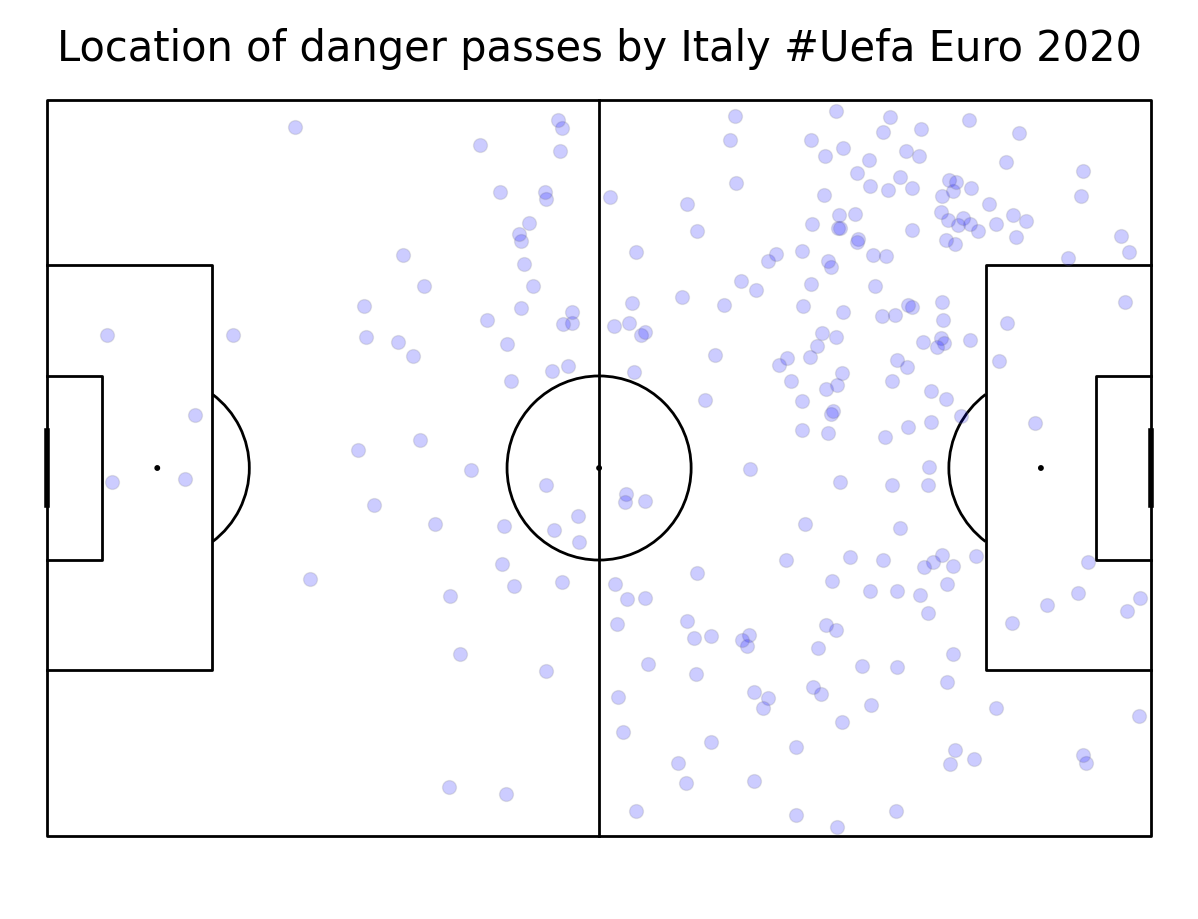

In [30]:
pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)

pitch.scatter(hot_pass.x, hot_pass.y, s=100, color='blue', edgecolors='grey', linewidth=1, alpha=0.2, ax=ax["pitch"])

#pitch.arrows(hot_pass.x, hot_pass.y, hot_pass.end_x, hot_pass.end_y, color = "blue", ax=ax['pitch'])

fig.suptitle('Location of danger passes by ' + club + ' #Uefa Euro 2020', fontsize = 30)
plt.show()

## Draw a Pass Heat Map

Disegniamo al solito il campo tramite la libreria mlpsoccer, in particolare con **Pitch**. 
Successivamente, specifichiamo i *bins*, ovvero in quanti quadrati verticali e orizzontali dividere il campo.
Poi utilizziamo l'istogramma 2D, che lo otterremo grazie al metodo **bin_statistic()**.

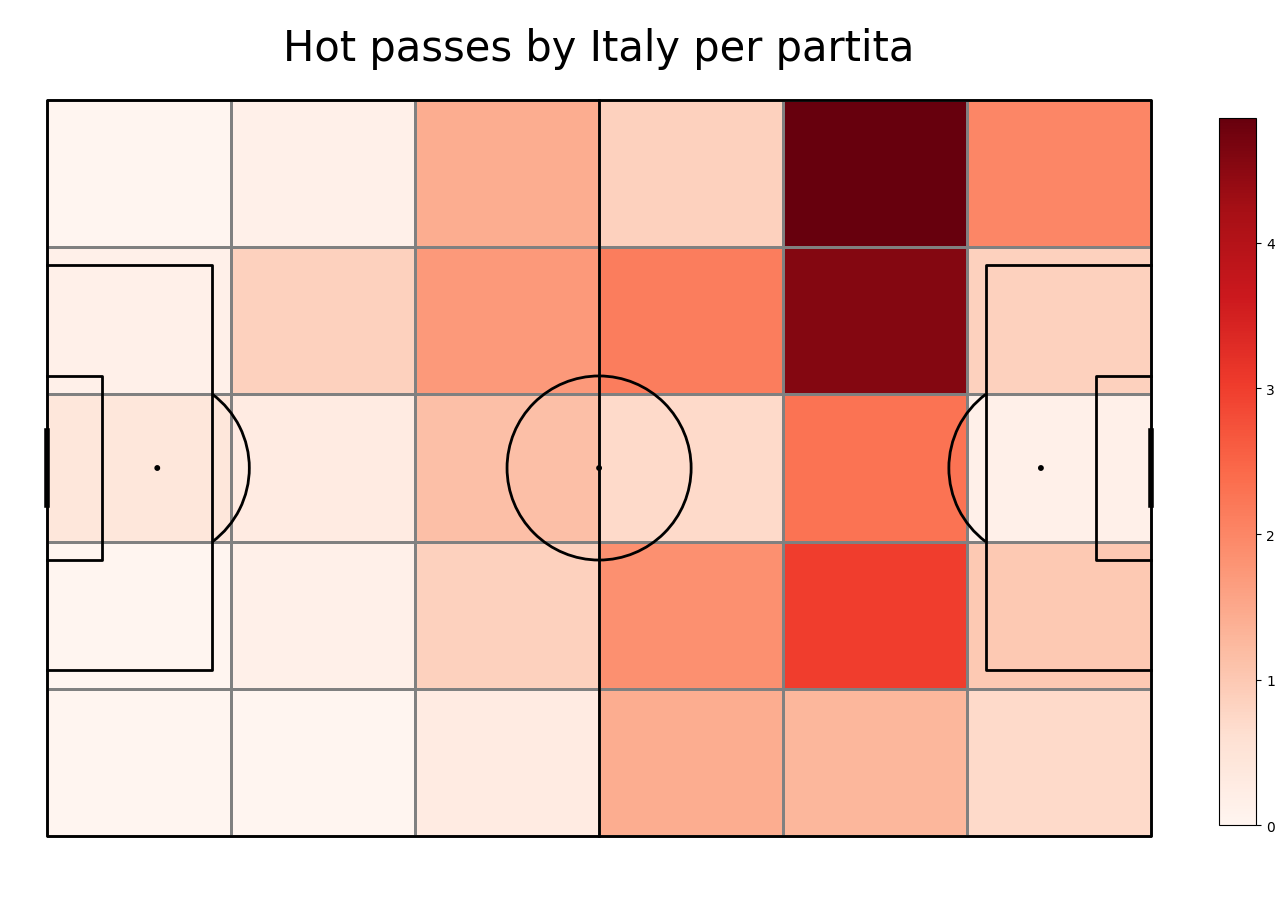

In [32]:
pitch = Pitch(line_zorder=2, line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)

#2D histogram
bin_statistic = pitch.bin_statistic(hot_pass.x, hot_pass.y, statistic='count', bins=(6, 5), normalize=False)

#normalizzazione per il numero totale di partite
bin_statistic["statistic"] = bin_statistic["statistic"]/n_matchs

#heatmap
heatmap = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

#leggenda
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(heatmap, cax=ax_cbar)
fig.suptitle('Hot passes by ' + club + " per partita", fontsize = 30)
plt.show()

Da questa mappa possiano notare che la fascia sinistra è molto più pericolosa di quella destra, in quanto molti passaggi effettuati 15 secondi prima di un tiro provengono proprio da li.

Adesso vediamo, tramite un grafico a barre, chi dei giocatori è stato più coinvolto nei passaggi pericolosi.

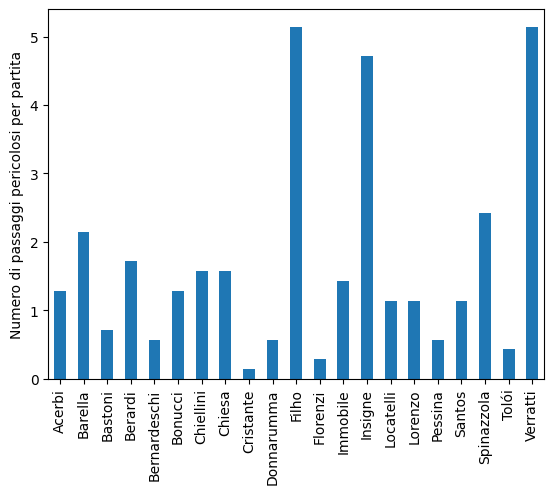

In [36]:
hot_pass["player_name"] = hot_pass["player_name"].apply(lambda x: str(x).split()[-1]) #solo cognome

#count passaggi per giocatore + normalizzazione
n_pass = hot_pass.groupby(["player_name"]).x.count()/n_matchs

ax = n_pass.plot.bar(n_pass)

ax.set_xlabel("")
ax.set_ylabel("Numero di passaggi pericolosi per partita")
plt.show()